In [1]:
import os
os.chdir("/home/newdisk/yangkai/contras_sum")
%load_ext autoreload
%autoreload 2

In [ ]:
import tqdm
from scl_data import summarize
def get_raw_data(path):
    raw_data = []
    f = open(path,"r")
    lines = f.readlines()
    f.close()
    for line in tqdm.tqdm_notebook(lines):
        line = line.strip()
        label, text = line.split(',',1)
        label = int(label[1])-1
        text = text[1:-1]
        sum = summarize(text)
        raw_data.append((label,text,sum))

    return raw_data

In [ ]:
train_path = "dataset/yelp_multi/yelp_review_full_csv/train.csv"
raw_train_data = get_raw_data(train_path)
test_path = "dataset/yelp_multi/yelp_review_full_csv/test.csv"
raw_test_data = get_raw_data(test_path)

In [ ]:
import torch
torch.save({"train":raw_train_data,"test":raw_test_data}, "dataset/yelp_multi/raw_data.pkl")

In [26]:
import torch
raw_dataset = torch.load("dataset/yelp_multi/raw_data_presum_6500.pkl")

In [27]:
import random
raw_train_data = raw_dataset["train"]
raw_test_data = raw_dataset["test"]
random.shuffle(raw_train_data)
random.shuffle(raw_test_data)

In [28]:
temp = {"1":[],"2":[],"3":[],"4":[],"5":[]}
for item in raw_train_data:
    label = item[0]
    temp[str(label + 1)].append(item)

few_shot_raw_train_data = temp["1"][:16] +  temp["2"][:16] + temp["3"][:16] + temp["4"][:16] +  temp["5"][:16] 
    

In [29]:
temp = {"1":[],"2":[],"3":[],"4":[],"5":[]}
for item in raw_test_data:
    label = item[0]
    temp[str(label + 1)].append(item)

few_shot_raw_test_data = temp["1"][:2000] +  temp["2"][:2000] + temp["3"][:2000] + temp["4"][:2000] +  temp["5"][:2000] 
    

In [30]:
torch.save({"train":few_shot_raw_train_data, "test":few_shot_raw_test_data},"dataset/yelp_multi/few_shot_raw_data_presum.pkl")

In [11]:
import torch
class multiLabelDataset(torch.utils.data.Dataset):
    def __init__(self,raw_data):
        self.data = raw_data

    def __getitem__(self,index):
        return self.data[index]

    def __len__(self):
        return len(self.data)
        
    

In [ ]:
import torch
train_dataset, test_dataset = torch.load("train_data.pkl")

In [ ]:
import random
random.shuffle(raw_train_data)
train_dataset = multiLabelDataset(raw_train_data[:6500])
test_dataset = multiLabelDataset(raw_test_data)

In [ ]:
from scl_data import summarize
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
def my_collect(batch):
    batch_size = len(batch)
    perm_index = torch.randperm(batch_size)
    y_a = torch.LongTensor([item[0] for item in batch])
    # print(y_a)
    # print(batch)
    y_b = y_a[perm_index]
    x = [item[1] for item in batch]
    # x_perm = [x[perm_index[i]] for i in range(batch_size)]
    # s = [summarize(x[i]) for i in range(batch_size)]
    s = [item[2] for item in batch]
    s_perm = [s[perm_index[i]] for i in range(batch_size)]
    s_mix = [s[i] + "\n" + s_perm[i] for i in range(batch_size)]

    x_ids = tokenizer(x, padding = 'max_length', max_length = 200, truncation = True, return_tensors="pt")["input_ids"]
    s_mix_ids = tokenizer(s_mix, padding = 'max_length', max_length = 200, truncation = True, return_tensors="pt")["input_ids"]

    return x_ids, s_mix_ids, y_a, y_b
    
    

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = 8,collate_fn = my_collect, num_workers=2, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = 32,collate_fn = my_collect, num_workers=2, shuffle = True)

In [ ]:
from scl_model import scl_model_multi
from transformers import RobertaForSequenceClassification, RobertaConfig
import torch
# device = torch.device(args.gpu_ids)
device = torch.device("cuda:0")
config = RobertaConfig.from_pretrained("roberta-base")
config.num_labels = 5
pretrained_model = RobertaForSequenceClassification.from_pretrained("roberta-base",config=config)
model = scl_model_multi(config,device,pretrained_model).to(device)

In [ ]:
from opt import OpenAIAdam
optimizer = OpenAIAdam(model.parameters(),
                                  lr=1e-5,
                                  schedule='warmup_linear',
                                  warmup=0.002,
                                  t_total=10000,
                                  b1=0.9,
                                  b2=0.999,
                                  e=1e-08,
                                  l2=0.01,
                                  vector_l2=True,
                                  max_grad_norm=1.0)

In [ ]:
def evaluate_model(model, test_loader, recoder, step):
    print("Evaluation Start======")
    model.eval()
    # TP, TN, FN, FP = 0, 0, 0, 0
    
    # step = 0
    bar = tqdm.tqdm(total=len(test_loader))
    bar.update(0)
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            x_ids, s_mix_ids, y_a, y_b = batch
            seq_ids = x_ids.to(device)
            labels = y_a.to(device)
            logits = model.predict(seq_ids)
            # print(logits)

            prediction = torch.argmax(logits, dim = 1)
            correct += (prediction == labels).sum().item()
            total += prediction.shape[0]

    acc = correct / total
    print("Acc: ",acc.item())

    recoder.log_test(acc.item(),step)

In [ ]:
import tqdm
class Recoder_multi():
    def __init__(self):
        self.ce_loss_x = []
        self.ce_loss_mix = []
        self.scl_loss = []
        self.loss = []
        self.acc = []
        self.step = []
    def log_train(self,ce_loss_x, ce_loss_mix, scl_loss,loss):
        self.ce_loss_x.append(ce_loss_x.item())
        self.ce_loss_mix.append(ce_loss_mix.item())
        self.scl_loss.append(scl_loss.item())
        self.loss.append(loss.item())
    
    def log_test(self,acc,step):
        self.acc.append(acc)
        self.step.append(step)


    def meter(self,step):
        print("===================================")
        print("loss: ",sum(self.loss)/step)
        print("ce_loss_x: ",sum(self.ce_loss_x)/step)
        print("ce_loss_mix: ",sum(self.ce_loss_mix)/step)
        print("scl_loss: ",sum(self.scl_loss)/step)


step = 0
bar = tqdm.tqdm(total=10000)
bar.update(0)
best_acc = 0
recoder = Recoder_multi()

loss_mask = [1,1,0.1]

count = 0
begin_eval = False
while(step < 10000):
    model.train()
    for batch in train_loader:
        # optimizer.zero_grad()
        ce_loss_x, ce_loss_mix, scl_loss = model(batch)
        loss = loss_mask[0] * ce_loss_x + loss_mask[1] * ce_loss_mix + loss_mask[2] * scl_loss
        loss.backward()

        recoder.log_train(ce_loss_x,ce_loss_mix,scl_loss,loss)

        count += 1
        if (count % 1 == 0):
            optimizer.step()
            step += 1
            optimizer.zero_grad()

            if (step % 200 == 0):
                begin_eval = True

            if (step % 10 == 0):
                bar.update(10)

        # step += 1
        
        
        if begin_eval:
            recoder.meter(step)
            evaluate_model(model,test_loader,recoder,step)
            torch.save(recoder,"log/run_multi_three_loss.pkl")
            
            model.train()
            begin_eval = False

In [7]:
import matplotlib.pyplot as plt
import torch
class Recoder_multi():
    def __init__(self,args):
        self.args = args
        self.ce_loss_x = []
        self.ce_loss_s = []
        self.scl_loss = []
        self.loss = []
        self.acc = []
        self.step = []
    def log_train(self,ce_loss_x, ce_loss_s, scl_loss,loss):
        self.ce_loss_x.append(ce_loss_x.item())
        self.ce_loss_s.append(ce_loss_s.item())
        self.scl_loss.append(scl_loss.item())
        self.loss.append(loss.item())
    
    def log_test(self,acc,step):
        self.acc.append(acc)
        self.step.append(step)


    def meter(self,step):
        print("===================================")
        print("step: ",step)
        print("loss: ",sum(self.loss)/step)
        print("ce_loss_x: ",sum(self.ce_loss_x)/step)
        print("ce_loss_s: ",sum(self.ce_loss_s)/step)
        print("scl_loss: ",sum(self.scl_loss)/step)
# log_baseline = torch.load("log/yelp_baseline_finetune_6500.pkl")
# log_scl = torch.load("log/with_mlp_without_mix_finetune.pkl")
# log_mix_scl = torch.load("log/with_mlp_with_mix_scl_finetune.pkl")
# log_together = torch.load("log/with_mlp_without_mix_together.pkl")
log_baseline_80 = torch.load("log/baseline_80_presum.pkl")
log_ucl_scl_80 = torch.load("log/scl_loss_80_presum_together.pkl")
log_scl_6500 = torch.load("log/scl_loss_6500_presum_together.pkl")


Text(0.5, 1.0, 'Test Acc VS Step')

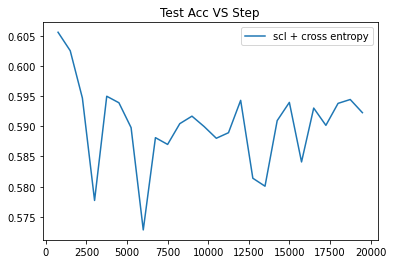

In [8]:
# plt.plot(log_baseline.step,log_baseline.acc,label = "baseline")
# plt.plot(log_scl.step,log_scl.acc,label = "scl pretraning + Finetuning")
# plt.plot(log_mix_scl.step,log_mix_scl.acc,label = "mix scl pretraining + Finetuning")
# plt.plot(log_together.step,log_together.acc,label = "Multi Objective")
# plt.plot(log_baseline_80.step, log_baseline_80.acc, label = "baseline")
# plt.plot(log_ucl_scl_80.step, log_ucl_scl_80.acc, label = "scl + cross entropy")
plt.plot(log_scl_6500.step, log_scl_6500.acc, label = "scl + cross entropy")
plt.legend()
plt.title("Test Acc VS Step")

Text(0.5, 1.0, 'Cross Entropy Loss Vs Step')

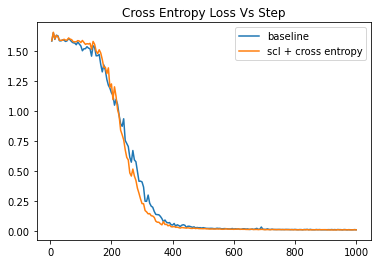

In [6]:
# plt.plot(log_scl.step,[sum(log_scl.ce_loss_x[i*750:(i+1)*750]) / 750 for i in range(20)],label = "scl pretrainig + Finetuning")
# plt.plot(log_baseline.step,[sum(log_baseline.ce_loss_x[i*750:(i+1)*750]) / 750 for i in range(20)], label = "baseline")
# plt.plot(log_mix_scl.step,[sum(log_mix_scl.ce_loss_x[i*750:(i+1)*750]) / 750 for i in range(20)], label = "mix scl pretraining + Finetuning")
# plt.plot(log_together.step,[sum(log_together.ce_loss_x[i*750:(i+1)*750]) / 750 for i in range(20)], label = "Multi Objective")
plt.plot(log_baseline_80.step,[sum(log_baseline_80.ce_loss_x[i*5:(i+1)*5]) / 5 for i in range(200)], label = "baseline")
plt.plot(log_ucl_scl_80.step,[sum(log_ucl_scl_80.ce_loss_x[i*5:(i+1)*5]) / 5 for i in range(200)], label = "scl + cross entropy")
plt.legend()
plt.title("Cross Entropy Loss Vs Step")

Text(0.5, 1.0, 'Scl Loss Vs Step')

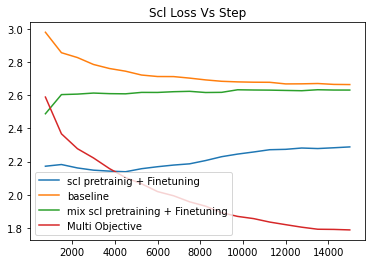

In [8]:
# plt.plot(log_scl.step,[sum(log_scl.scl_loss[i*750:(i+1)*750]) / 750 for i in range(20)],label = "scl pretrainig + Finetuning")
# plt.plot(log_baseline.step,[sum(log_baseline.scl_loss[i*750:(i+1)*750]) / 750 for i in range(20)], label = "baseline")
# plt.plot(log_mix_scl.step,[sum(log_mix_scl.scl_loss[i*750:(i+1)*750]) / 750 for i in range(20)], label = "mix scl pretraining + Finetuning")
# plt.plot(log_together.step,[sum(log_together.scl_loss[i*750:(i+1)*750]) / 750 for i in range(20)], label = "Multi Objective")
plt.plot(log_baseline_80.step,[sum(log_baseline_80.scl_loss[i*10:(i+1)*10]) / 10 for i in range(400)], label = "baseline")
plt.plot(log_ucl_scl_80.step,[sum(log_ucl_scl_80.scl_loss[i*10:(i+1)*10]) / 10 for i in range(400)], label = "ucl+scl")
plt.legend()
plt.title("Scl Loss Vs Step")

In [2]:
import torch
presum_data = torch.load("dataset/yelp_multi/6500_train_data.pkl")

In [19]:
from scl_data import summarize
raw_data_presum = []
count = 0
for i in range(len(presum_data["text"])):
    text = presum_data["text"][i]
    label = presum_data["label"][i]
    sum = presum_data["sum"][i]

    text = text.strip()
    sum = sum.strip()
    sum = sum.replace("<q>",". ")
    if "....." in sum or "this this" in sum or "is is is" in sum:
        sum = summarize(text)
        count += 1
    print(sum)

    raw_data_presum.append((label,text,sum))


italian restaurant in shadyside. it gets crowded and hectic on friday and staurday nights
the meatball was the highlight: twelve ounces of perfectly cooked beef. also adorning our table were a few clothing options in which to dress the bread. as a table we compiled quite the culinary collection
i usually go for late lunch on weekdays and have no problem at all getting a table right away or my food coming out quickly
i grew up in pittsburgh and now live in san jose. i can tell you we do not have stores like this where i live now
i used to live uptown and would come here for lunch often. i 'm not a cornbread fan but i do love their cornbread
love casbah have been going there for years and have never had a less than great meal and service. everything is well-prepared and the service is among the best in the -burgh
blueberry pancakes pancakes were blueberry pancakes. blueberry pancakes were the blueberry pancakes
i called yesterday as the driver headlight on my car was out and asked if i n

In [25]:
import torch
torch.save({"train":raw_data_presum,"test":raw_test_data},"dataset/yelp_multi/raw_data_presum_6500.pkl")